# K-means Cluster Heatmaps

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram

expression = pd.read_csv("akt_ar_signaling.csv")
#expression.set_index("Unnamed: 0")
expression = expression.set_index(expression["Unnamed: 0"])
expression = expression.drop("Unnamed: 0", axis = 1)
expression = expression.dropna(axis = 1)
print(expression.head())

               wt     ar  pten    ap2
Unnamed: 0                           
STEAP2      15.63   7.35  9.90   5.13
S100A16      3.51   8.94  3.33  10.50
PTEN        12.68  12.71  6.18   8.08
STEAP1      14.45   8.21  8.08   5.13
CRACR2A      5.60   5.91  5.80  11.01


In [2]:
data = expression

# # List to store WCSS for each number of clusters
# wcss = []

# # Loop over possible values of k (number of clusters)
# for num_clusters in range(1, 30):  # You can adjust the range based on your data
#     kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
#     kmeans.fit(data)
#     wcss.append(kmeans.inertia_)  # WCSS is stored in inertia_

# # Plot the Elbow plot
# plt.figure(figsize=(8, 6))
# plt.plot(range(1, 30), wcss, marker='o', linestyle='--')
# plt.title('Elbow Method for Optimal k')
# plt.xlabel('Number of Clusters')
# plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
# plt.xticks(np.arange(1, 30))
# plt.grid(True)
# plt.show()

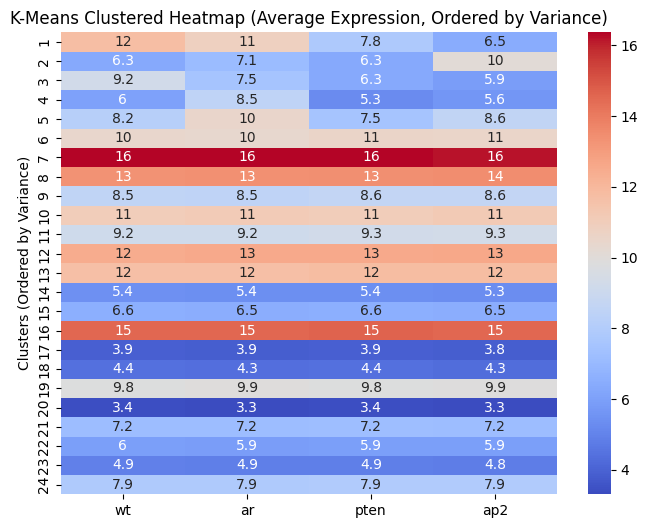

In [3]:
num_clusters = 24 # The rationale for 4! is that all possible combinations (ie. high, low, low, low) can be captured
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(data)
data["Cluster"] = clusters

clustered_data = data.groupby("Cluster").mean()

cluster_variances = clustered_data.var(axis=1)

# Sort clusters by variance (highest variance first) and reassign labels
sorted_clusters = cluster_variances.sort_values(ascending=False).index
cluster_mapping = {old: new for new, old in enumerate(sorted_clusters, start=1)}
data["Cluster"] = data["Cluster"].map(cluster_mapping)

clustered_data = clustered_data.loc[sorted_clusters]
clustered_data.index = [cluster_mapping[idx] for idx in clustered_data.index]

# Plot heatmap for averaged clusters
plt.figure(figsize=(8, 6))
sns.heatmap(clustered_data, cmap="coolwarm", xticklabels=True, yticklabels=True, annot=True)

plt.title("K-Means Clustered Heatmap (Average Expression, Ordered by Variance)")
plt.ylabel("Clusters (Ordered by Variance)")
plt.show()

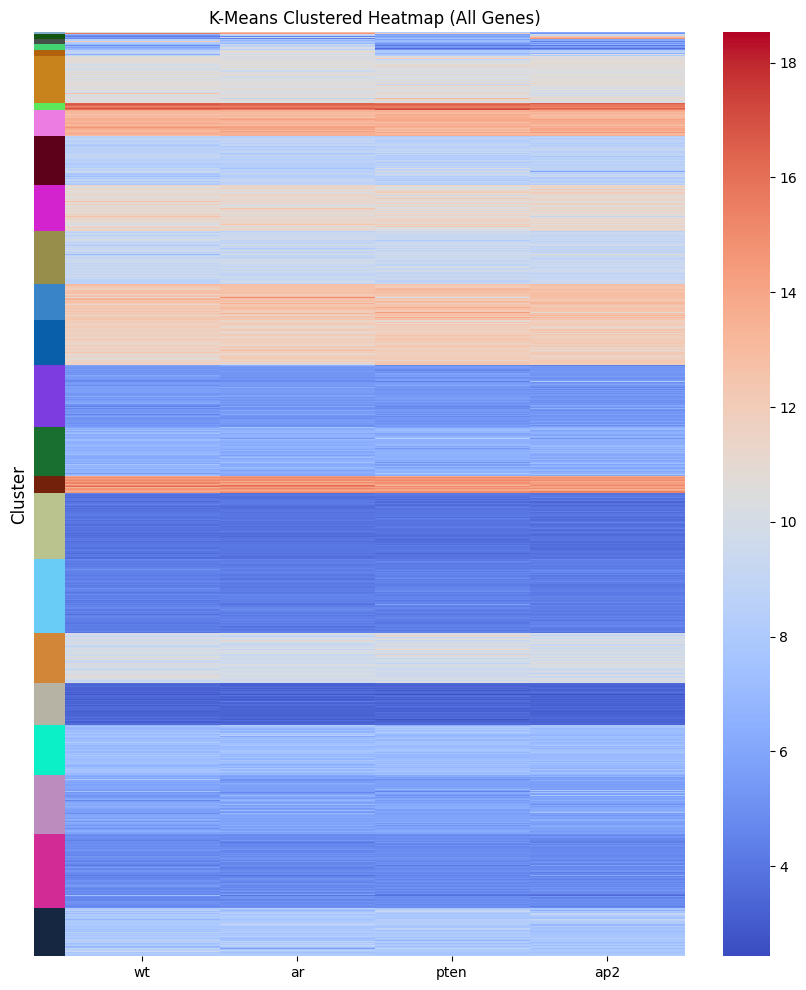

In [4]:
from matplotlib.colors import ListedColormap

# Reorder full dataset by new cluster labels
data_sorted = data.sort_values(by="Cluster")

# Get the number of unique clusters
num_clusters = data_sorted["Cluster"].nunique()

# Generate a random colormap for clusters
random_colors = np.random.rand(num_clusters, 3)  # Random RGB colors
cluster_cmap = ListedColormap(random_colors)  # Create colormap

# Create a figure for both heatmaps
plt.figure(figsize=(10, 12))

# Create a main heatmap for the data (without the cluster column)
sns.heatmap(data_sorted.drop(columns=["Cluster"]), cmap="coolwarm", xticklabels=True, yticklabels=False)

# Create an inset axis for the color bar (cluster labels)
cbar_ax = plt.gca().inset_axes([-0.05, 0, 0.05, 1])  # Thin vertical color bar on the left side

# Plot the cluster labels as a heatmap on the left side using the random colormap
sns.heatmap(data_sorted[['Cluster']], cmap=cluster_cmap, cbar=False, xticklabels=False, yticklabels=False, ax=cbar_ax)

# Add y-axis label for the inset color bar
cbar_ax.set_ylabel('Cluster', fontsize=12)

# Remove any index column label (this is likely where "Unnamed: 0" comes from)
plt.gca().set_ylabel("")  # This removes the y-axis label on the second heatmap

# Adjust layout and finalize the plot
plt.title("K-Means Clustered Heatmap (All Genes)")
plt.show()

In [5]:
# Getting rid of semi-colons for Enrichr

list_of_clusters = []
for cluster_num in range(1, num_clusters + 1): 
    genes_in_cluster = data[data["Cluster"] == cluster_num].index.to_list()
    list_of_clusters.append(genes_in_cluster)
    
j = 1
for cluster in list_of_clusters:
    i = 0
    while i < len(cluster):
        if ';' in cluster[i]:
            split_genes = cluster[i].split(';')
            cluster[i:i+1] = split_genes  # Replace the original gene with the split genes
            i += len(split_genes) - 1  # Skip over the new elements added
        i+=1
#     print(f"Cluster {j}:")
#     print(cluster)
    j+=1

# Over-representation Analysis

In [6]:
import gseapy as gp
# human = gp.get_library_name(organism='Human')

# for geneset_library in human:
#     if "hallmark" in geneset_library.lower():
#         print(geneset_library)

# library = gp.get_library(name="GO_Biological_Process_2025", organism="Human")
# print(library.keys())

In [7]:
cluster = list_of_clusters[1]
print(f"Cluster size: {len(cluster)}")
print()
print(cluster)

enr = gp.enrich(gene_list=cluster, # or gene_list=glist
                 gene_sets=["data/bp_2024.gmt", "data/cc_2024.gmt", "data/mf_2024.gmt", "data/hallmark_2024.gmt"], # kegg is a dict object
                 background=data.index.to_list(),
                 outdir=None,
                 verbose=False)

enr.results.loc[enr.results["Adjusted P-value"] < 0.05]

Cluster size: 114

['S100A16', 'CRACR2A', 'NTRK2', 'S100A4', 'IGFBP5', 'KCND2', 'S100A14', 'FAM101A', 'ATP12A', 'S100A6', 'PLA2G2A', 'LURAP1L', 'BNIPL', 'TIMP3', 'TWIST1', 'VAV3', 'TFAP2C', 'PADI2', 'MISP', 'TLE1', 'EPHB3', 'FREM2', 'FAIM2', 'ST3GAL5', 'ITGB4', 'C1QTNF6', 'TNFSF10', 'C9orf152', 'FAM177B', 'CDCA7L', 'FRMD6', 'VTCN1', 'FSTL3', 'KIAA1217', 'RAB25', 'PSMB8', 'BCAS1', 'PRSS12', 'CEP295NL', ' TIMP2', 'SLC2A10', 'DEGS2', 'ATP2B4', 'CDH18', 'PRODH', 'MSX2', 'C4orf19', 'PYCARD', 'CREB3L4', 'BOC', 'PLD1', 'MYO1B', 'PLK2', 'KDELR3', 'DIO2', 'SOSTDC1', 'DSCR8', 'ANXA1', 'PLP2', 'SLC25A29', 'ST3GAL4', 'RNF152', 'MGLL', 'PTHLH', 'CNTN4', 'JAK1', 'COL17A1', ' MIR936', 'SPTSSB', 'PCDH11X', 'NABP1', 'FAM19A2', 'TRIM38', 'SEMA6D', 'ADGRL2', 'GABRQ', 'ARHGAP24', 'TRIM47', 'TRIM29', 'AOC1', 'GPER1', 'GNB4', 'MFAP2', 'ST6GALNAC2', 'C10orf11', 'SGK1', 'ALDH3B2', 'HEY1', 'PCDH11Y', 'SLC16A7', 'IER5', 'CDH12', 'CRABP2', 'CRABP1', 'FLRT3', 'CPS1', 'CNTNAP3P2', ' CNTNAP3', 'CDC42EP3', 'CSMD3', 

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
36,bp_2024.gmt,GOBP_AMEBOIDAL_TYPE_CELL_MIGRATION,8/402,0.001170,0.042985,4.371155,29.507171,ANXA1;RAB25;SEMA6D;ATP2B4;ITGB4;PLK2;KITLG;TWIST1
77,bp_2024.gmt,GOBP_ARACHIDONIC_ACID_SECRETION,3/31,0.000548,0.042985,24.113991,181.085810,PLA2G3;ANXA1;PLA2G2A
90,bp_2024.gmt,GOBP_AXON_DEVELOPMENT,9/494,0.001073,0.042985,3.993121,27.301009,BOC;FLRT3;S100A6;SEMA6D;IGSF9;NTRK2;EPHB3;CRAB...
105,bp_2024.gmt,GOBP_BLOOD_VESSEL_MORPHOGENESIS,10/590,0.000981,0.042985,3.712508,25.717047,VAV3;ANXA1;HEY1;ATP2B4;PLK2;NTRK2;ARHGAP24;TWI...
132,bp_2024.gmt,GOBP_CANONICAL_NF_KAPPAB_SIGNAL_TRANSDUCTION,7/287,0.000742,0.042985,5.399530,38.906893,TLE1;S100A4;PYCARD;TNFSF10;PLK2;TRIM38;LURAP1L
...,...,...,...,...,...,...,...,...
2351,mf_2024.gmt,GOMF_CELL_ADHESION_MEDIATOR_ACTIVITY,4/65,0.000362,0.020063,14.488919,114.801249,TRIM29;ANXA1;IGSF9;CNTN4
2353,mf_2024.gmt,GOMF_CELL_CELL_ADHESION_MEDIATOR_ACTIVITY,4/52,0.000152,0.011932,18.384793,161.573561,TRIM29;ANXA1;IGSF9;CNTN4
2397,mf_2024.gmt,GOMF_FIBRONECTIN_BINDING,3/29,0.000449,0.020063,25.936570,199.950066,IGFBP5;MFAP2;FSTL3
2565,mf_2024.gmt,GOMF_SIALYLTRANSFERASE_ACTIVITY,3/20,0.000145,0.011932,39.293467,347.357983,ST6GALNAC2;ST3GAL4;ST3GAL5


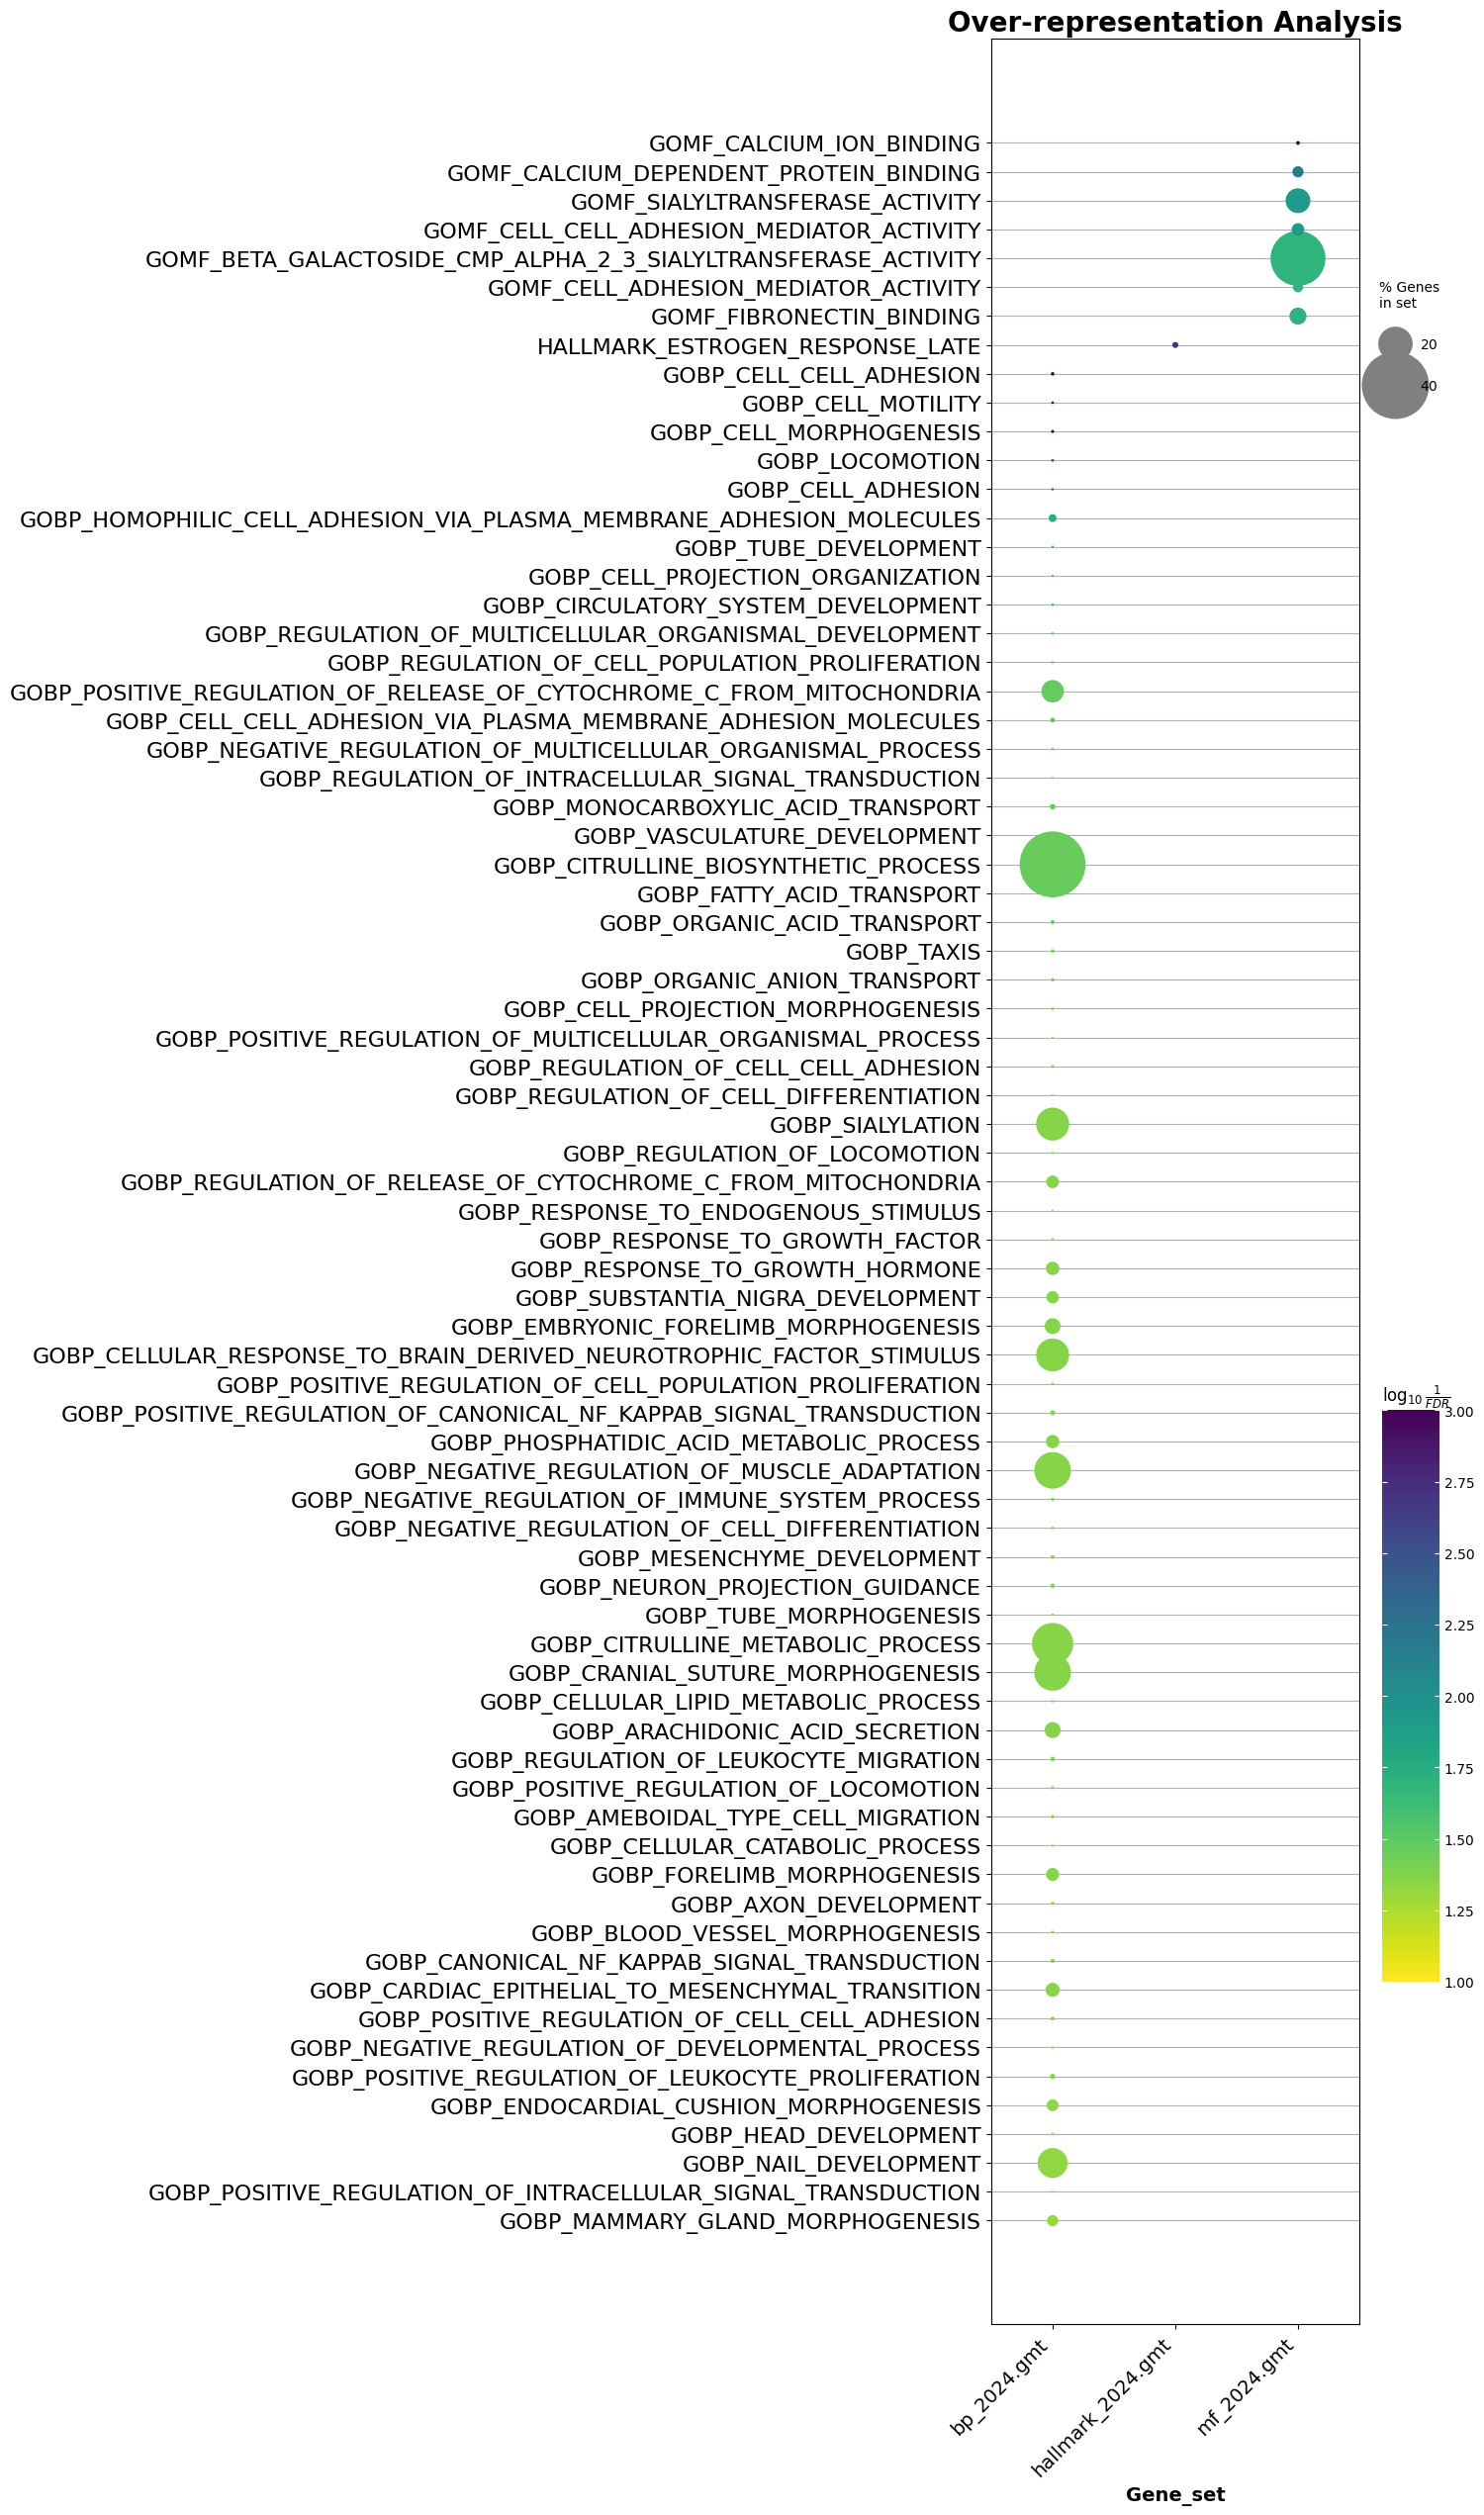

In [8]:
from gseapy import barplot, dotplot
ax = dotplot(enr.results,
              column="Adjusted P-value",
              x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
              size=20,
              top_term=70,
              figsize=(6,30),
              title = "Over-representation Analysis",
              xticklabels_rot=45, # rotate xtick labels
              show_ring=False, # set to False to revmove outer ring
              marker='o',
             )